# Introduction to Recommendation Systems

In [ ]:
#@title Copyright
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recommendation Systems with TensorFlow

Link to this colab: [bit.ly/recsys-colab](http://bit.ly/recsys-colab)

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

If possible, use a runtime with a GPU. This can be done using **Runtime**->**Change runtime type**.

# Introduction

We will create a movie recommendation system based on the [MovieLens](https://movielens.org/) dataset available [here](http://grouplens.org/datasets/movielens/).  The data consists of movies ratings (on a scale of 1 to 5).

## Outline
  1. Exploring the MovieLens Data (10 minutes)
  1. Preliminaries (25 minutes)
  1. Training a matrix factorization model (15 minutes)
  1. Inspecting the Embeddings (15 minutes)
  1. Regularization in matrix factorization (15 minutes)

## Setup

Let's get started by importing the required packages.

In [ ]:
# @title Imports (run this cell)
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_eager_execution()

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

# Install and import UMAP for embedding visualization.
print("Installing UMAP...")
!pip install umap-learn
import umap
print("Done installing UMAP.")

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-flzr7rtb
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-flzr7rtb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.3.0.dev0-py3-none-any.whl size=812981 sha256=2f9f3d6214e4f7f783b9643d0712b5d47351e0f5e9c0c6748cfa3a3b89ccd7fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-9s34ti_y/wheels/06/13/e0/5bd72c969fe3954ee1561739e5c58e2ddfe5c10fcdffb12faa
Successfully built altair
  Attempting uninstall: altair
    Found existing installation: altair 4.2.0
    Uninstalling altair-4.2.0:
      Successfully uninstalled altair-4.2.0
Done installing Altair.
Installing UMAP...
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 65.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-

We then download the MovieLens Data, and create DataFrames containing movies, users, and ratings.

In [ ]:
# @title Load the MovieLens data (run this cell).

# Download MovieLens data.
print("Downloading movielens data...")
import urllib.request
import zipfile

urllib.request.urlretrieve("https://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-1m/users.dat', sep='::', names=users_cols, encoding='utf-8')

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(
    'ml-1m/ratings.dat', sep='::', names=ratings_cols, encoding='utf-8')

movies_cols = [
    'movie_id', 'title', 'all_genres'
]
movies = pd.read_csv(
    'ml-1m/movies.dat', sep='::', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: x-1)
movies["movie_id"] = movies["movie_id"].apply(lambda x: x-1)
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: x-1)
ratings["user_id"] = ratings["user_id"].apply(lambda x: x-1)
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies):
  def get_random_genre(gs):
    # active = [genre for genre, g in zip(genres, gs) if g==1]
    active = gs.split("|")
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  movies['genre'] = movies["all_genres"].apply(get_random_genre)

mark_genres(movies)

# Create one merged DataFrame containing all the movielens data.
# movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

def num_users():
  return ratings['user_id'].max() + 1

def num_movies():
  return ratings['movie_id'].max() + 1

print(f"Num users: {num_users()}")
print(f"Num movies: {num_movies()}")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Num users: 6040
Num movies: 3952


# I. Exploring the Movielens Data
Before we dive into model building, let's inspect our MovieLens dataset. It is usually helpful to understand the statistics of the dataset.

### Users
We start by printing some basic statistics describing the numeric and categorical user features.

In [ ]:
users.describe(include=[np.object, int])

user_id gender      age  occupation zip_code
count  6040.000   6040 6040.000    6040.000     6040
unique      NaN      2      NaN         NaN     3439
top         NaN      M      NaN         NaN    48104
freq        NaN   4331      NaN         NaN       19
mean   3019.500    NaN   30.639       8.147      NaN
std    1743.742    NaN   12.896       6.330      NaN
min       0.000    NaN    1.000       0.000      NaN
25%    1509.750    NaN   25.000       3.000      NaN
50%    3019.500    NaN   25.000       7.000      NaN
75%    4529.250    NaN   35.000      14.000      NaN
max    6039.000    NaN   56.000      20.000      NaN

We can also create histograms to further understand the distribution of the users. We use Altair to create an interactive chart.

In [ ]:
# @title Altair visualization code (run this cell)
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
# sort=alt.SortField(op="count", order='ascending')
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

def hist(field, label, step):
  return alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(step=step, maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)


Next, we look at the distribution of ratings per user.

How might this distribution affect the recommendations?

In [ ]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    hist('rating count', '# ratings / user', step=200),
    hist('rating mean', 'mean user rating', step=0.5),
    data=users_ratings)

alt.HConcatChart(...)

### Movies

It is also useful to look at information about the movies and their ratings.

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

title  ...  rating mean
2651                             American Beauty (1999)  ...        4.317
253           Star Wars: Episode IV - A New Hope (1977)  ...        4.454
1106  Star Wars: Episode V - The Empire Strikes Back...  ...        4.293
1120  Star Wars: Episode VI - Return of the Jedi (1983)  ...        4.023
466                                Jurassic Park (1993)  ...        3.764
1848                         Saving Private Ryan (1998)  ...        4.337
575                   Terminator 2: Judgment Day (1991)  ...        4.059
2374                                 Matrix, The (1999)  ...        4.316
1178                          Back to the Future (1985)  ...        3.990
579                    Silence of the Lambs, The (1991)  ...        4.352

[10 rows x 3 columns]

Finally, the last chart shows the distribution of the number of ratings and average rating.

Clicking on a genre in the right chart will filter the data by that genre. The corresponding histogram is shown in blue, and superimposed with the histogram for the whole data (in light gray). You can use SHIFT+click to select multiple genres.

In [ ]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each rwo $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



## Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

#### Toy example
Assume we have $2$ users and $4$ movies. Our toy ratings dataframe has three ratings,

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

The corresponding rating matrix is

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

And the SparseTensor representation is,
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



### Exercise 1: Build a tf.SparseTensor representation of the Rating Matrix.

In this exercise, we'll write a function that maps from our `ratings` DataFrame to a `tf.SparseTensor`.

Hint: you can select the values of a given column of a Dataframe `df` using `df['column_name'].values`.

In [ ]:
ratings

user_id  movie_id  rating  timestamp
0              0      1192   5.000  978300760
1              0       660   3.000  978302109
2              0       913   3.000  978301968
3              0      3407   4.000  978300275
4              0      2354   5.000  978824291
...          ...       ...     ...        ...
1000204     6039      1090   1.000  956716541
1000205     6039      1093   5.000  956704887
1000206     6039       561   5.000  956704746
1000207     6039      1095   4.000  956715648
1000208     6039      1096   4.000  956715569

[1000209 rows x 4 columns]

In [ ]:
#@title
def build_rating_sparse_tensor(ratings):
  """
  Args:
    ratings: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
  # ========================= Complete this section ============================
  # indices =
  # values =
  # ============================================================================

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users(), num_movies()])

In [ ]:
#@title Solution
def build_rating_sparse_tensor(ratings):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings[['user_id', 'movie_id']].values
  values = ratings['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users(), num_movies()])

## Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.



### Exercise 2: Mean Squared Error

Write a TensorFlow function that takes a sparse rating matrix $A$ and the two embedding matrices $U, V$ and returns the mean squared error $\text{MSE}(A, UV^\top)$.

Hints:
  * in this section, we only consider observed entries when calculating the loss.
  * a `SparseTensor` `sp_x` is a tuple of three Tensors: `sp_x.indices`, `sp_x.values` and `sp_x.dense_shape`.
  * you may find [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd) and  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error) helpful.

In [ ]:
#@title
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # ========================= Complete this section ============================
  # loss =
  # ============================================================================
  return loss

In [ ]:
#@title Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),  # prediction matrix
      sparse_ratings.indices)  # observed part of the ground truth matrix
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Note: One approach is to compute the full prediction matrix $UV^\top$, then gather the entries corresponding to the observed pairs. The memory cost of this approach is $O(NM)$. For the MovieLens dataset, this is fine, as the dense $N \times M$ matrix is small enough to fit in memory ($N = 6040$, $M = 3951$).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is $O(|\Omega| d)$ where $d$ is the embedding dimension. In our case, $|\Omega| = 10^5$, and the embedding dimension is on the order of $10$, so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

In [ ]:
#@title Alternate Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

### Exercise 3 (Optional): adding your own ratings to the data set

You have the option to add your own ratings to the data set. If you choose to do so, you will be able to see recommendations for yourself.

Start by checking the box below. Running the next cell will authenticate you to your google Drive account, and create a spreadsheet, that contains all movie titles in column 'A'. Follow the link to the spreadsheet and take 3 minutes to rate some of the movies. Your ratings should be entered in column 'B'.

In [ ]:
#@title Enter some ratings.
import IPython
from IPython import display
from google.colab import output

def add_user_ratings(ratings_df, movies_df):
  """Creates an HTML table that updates a user ratings np.array.
  
  Args:
    ratings_df:
    movies_df:
  """
  movies_list = movies_df[["movie_id", "title"]].values
  # movies_list = movies_list[:10, :]
  user_ratings = {}
  def update_value(id, value):
    try:
      val = int(value)
      if not 0 <= val <= 5:
        raise ValueError()
    except:
      print(f"\rInvalid rating {value}: please use an integer in [0, 5]", end="")
      return

    print(f"\rRegistering rating {value} for movide {id}", end="")
    user_ratings[int(id)] = float(value)
  
  output.register_callback('notebook.update_value', update_value)
  
  html = '''
  <input type="text" id="myFilter" onkeyup="filterFn()" placeholder="Type to filter">
    <table id="myTable">
      <style>
      table, th, td {
        border: 1px solid black;
        border-collapse: collapse;
      }
    </style>
    <thead>
        <tr border: solid;>
            <th colspan="1">Movie</th>
            <th>Rating</th>
        </tr>
    </thead>
    <tbody>
  '''
  for movie_id, title in movies_list:
    html += '''
        <tr>
            <td>%s</td>
            <td><input id='%d' value='0' onblur='google.colab.kernel.invokeFunction("notebook.update_value", [], {id: this.id, value: this.value}) '></td>
        </tr>
        ''' % (title, int(movie_id))
  html += '''
    </tbody>
    </table>
    <script>
    function filterFn() {
      // Declare variables
      var input, filter, table, tr, td, i, txtValue;
      input = document.getElementById("myFilter");
      filter = input.value.toUpperCase();
      table = document.getElementById("myTable");
      tr = table.getElementsByTagName("tr");

      // Loop through all table rows, and hide those who don't match the search query
      for (i = 0; i < tr.length; i++) {
        td = tr[i].getElementsByTagName("td")[0];
        if (td) {
          txtValue = td.textContent || td.innerText;
          if (txtValue.toUpperCase().indexOf(filter) > -1) {
            tr[i].style.display = "";
          } else {
            tr[i].style.display = "none";
          }
        }
      }
    }
    </script>
    '''
  display.display(display.HTML(html))

  return user_ratings


user_ratings = add_user_ratings(ratings, movies)

Registering rating 5 for movide 3938

In [ ]:
#@title Load your ratings
def load_user_ratings(ratings, users):
  if not user_ratings:
    return ratings, users
  new_ratings = collections.defaultdict(list)
  for k, v in user_ratings.items():
    if v:
      new_ratings["user_id"].append(6040)
      new_ratings["movie_id"].append(k)
      new_ratings["rating"].append(float(v))
  # Remove previous ratings.
  ratings = ratings[ratings["user_id"] != 6040]
  # Add new ratings.
  ratings = ratings.append(pd.DataFrame(new_ratings), ignore_index=True)
  # Add new user to the users DataFrame.
  if users.shape[0] == 6040:
    new_user = {
        "user_id": 6040,
    }
    users = users.append(new_user, ignore_index=True)
  print(f"Added your {len(user_ratings)} ratings; you have great taste!")
  # ratings[ratings.user_id=="943"].merge(movies[['movie_id', 'title']])
  return ratings, users

ratings, users = load_user_ratings(ratings, users)

Added your 5 ratings; you have great taste!


# III. Training a Matrix Factorization model

## CFModel (Collaborative Filtering Model) helper class
This is a simple class to train a matrix factorization model using stochastic gradient descent.

The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error)

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [ ]:
# @title CFModel helper class (run this cell)
%matplotlib inline
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics):
    """Initializes a CFModel.
    Args:
      embedding_vars: list of tf.Variable of the user and movie embeddings.
      loss: A float Tensor. The loss to optimize.
      metrics: optional dictionary of Tensors, to be plotted during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    if not isinstance(metrics, list):
      metrics = [metrics]
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()  # initializes local variables, e.g. optimizer variables.
      iterations = []
      metrics = self._metrics or [{}]
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]
      # Train and append results.
      num_subplots = len(metrics)+1
      fig = plt.figure()
      fig.set_size_inches(num_subplots*6, 5)
      axs = [fig.add_subplot(1, num_subplots, i) for i in range(1, num_subplots)]
      for i in range(num_iterations + 1):
        _ = self._session.run(train_op)
        if (i % 50 == 0) or i == num_iterations:
          results = self._session.run(metrics)
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)
          if plot_results:
            # Plot the metrics.
            display.clear_output(wait=True)
            for metric_vals, ax in zip(metrics_vals, axs):
              ax.clear()
              ax.set_xlim([1, num_iterations])
              for k, v in metric_vals.items():
                ax.plot(iterations, v, label=k)
              ax.legend()
            display.display(plt.gcf())
          print("iteration %d:" % i)
          for r in results:
            for k, v in r.items():
              print("%s \t = %f" % (k, v))

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()
      plt.close(1)  # to avoid displaying a duplicate figure.

      return results


def get_recall(sp_x, U, V, k):
  """Creates recall metrics for a given data matrix."""
  predictions = tf.matmul(U, V, transpose_b=True)
  labels = tf.sparse.reorder(tf.SparseTensor(
      indices=sp_x.indices,
      values=sp_x.indices[:, 1],
      dense_shape=sp_x.dense_shape))
  _, recall = tf.metrics.recall_at_k(labels, predictions, k=k)
  return recall

### Exercise 4: Build a Matrix Factorization model and train it

Using your `sparse_mean_square_error` function, write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
    k: if not None, plots the recall at k.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  # ========================= Complete this section ============================
  # A_train =
  # A_test =
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [num_users(), embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [num_movies(), embedding_dim], stddev=init_stddev))
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  # ========================= Complete this section ============================
  # train_loss =
  # test_loss =
  # ============================================================================
  metrics = [{'train_error': train_loss, 'test_error': test_loss}]
  return CFModel(embeddings, train_loss, metrics)

In [ ]:
#@title Solution
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [num_users(), embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [num_movies(), embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)

  metrics = [
      {'train_error': train_loss, 'test_error': test_loss},
      {'train Recall@10': get_recall(A_train, U, V, k=10),
       'test  Recall@10': get_recall(A_test, U, V, k=10)},
  ]
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, metrics)

Great, now it's time to train the model!

Go ahead and run the next cell, trying different parameters (embedding dimension, learning rate, iterations). The training and test errors are plotted at the end of training. You can inspect these values to validate the hyper-parameters.

Note: by calling `model.train` again, the model will continue training starting from the current values of the embeddings.

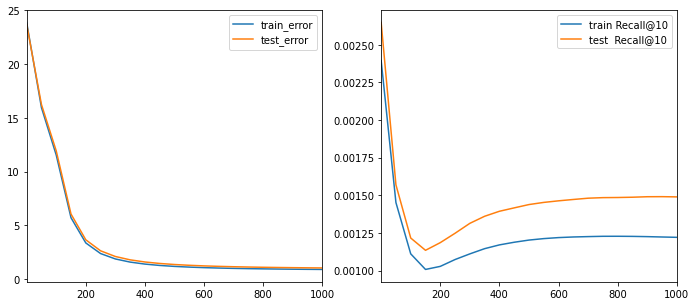

iteration 1000:
train_error 	 = 0.890479
test_error 	 = 1.029925
train Recall@10 	 = 0.001221
test  Recall@10 	 = 0.001490


In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=10, init_stddev=1.0)
results = model.train(num_iterations=1000, learning_rate=10.)

Note: while the scale of the problem is small enough to allow efficient training using GD, larger models need to be trained using more specialized algorithms such as Weighted Alternating Least Squares (see [tf.contrib.factorization.WALSMatrixFactorization](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) for a TF implementation).

# IV. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

### Exercise 5: Write a function that computes the scores of the candidates
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

As discussed in the lecture, there are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  # ========================= Complete this section ============================
  # scores =
  # ============================================================================
  return scores

In [ ]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Equipped with this function, we can compute recommendations, where the query embedding can be either a user embedding or a movie embedding.

In [ ]:
# @title User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if model.embeddings["user_id"].shape[0] < 6041:
    print("No user ratings were found. Make sure to run the load_user_rating() function and rerun training.")
    return
  scores = compute_scores(
      model.embeddings["user_id"][6040], model.embeddings["movie_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: scores[movies['movie_id']],
      'movie_id': movies['movie_id'],
      'titles': movies['title'],
      'genres': movies['all_genres'],
  })
  if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == 6040]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
  display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  all_titles = movies['title'].str.lower()
  mask = all_titles.str.contains(title_substring.lower())
  # ids =  movies[mask]["movie_id"]
  titles = movies[mask]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = movies[mask]["movie_id"].values[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: scores[movies['movie_id']],
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Your recommendations

If you chose to input your recommendations, you can run the next cell to generate recommendations for you.

In [ ]:
user_recommendations(model, measure=COSINE, k=20)

cosine score  ...                  genres
3463         0.868  ...                  Comedy
779          0.865  ...                   Drama
744          0.826  ...    Adventure|Children's
3314         0.825  ...           Drama|Musical
1477         0.799  ...                  Comedy
3821         0.790  ...             Crime|Drama
2224         0.785  ...                   Drama
2854         0.755  ...                  Comedy
1808         0.750  ...                   Drama
2986         0.736  ...                Thriller
3865         0.734  ...                  Horror
2478         0.721  ...                   Drama
2060         0.716  ...             Documentary
283          0.711  ...  Action|Sci-Fi|Thriller
2195         0.709  ...                   Drama
1328         0.694  ...                  Horror
2606         0.692  ...    Comedy|Drama|Romance
1444         0.684  ...          Crime|Thriller
1535         0.683  ...                   Drama
3473         0.682  ...                   Drama

[20 rows x 4 columns]

How do the recommendations look?

### Movie Nearest neighbors

Let's look at the neareast neighbors for some of the movies.

In [ ]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...              genres
315       6.819  ...               Drama
847       6.788  ...  Action|Crime|Drama
523       6.774  ...           Drama|War
1132      6.765  ...    Animation|Comedy
49        6.762  ...      Crime|Thriller
1950      6.762  ...        Action|Drama

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                               genres
584          1.000  ...  Animation|Children's|Comedy|Musical
1568         1.000  ...                      Action|Thriller
3078         1.000  ...                       Drama|Thriller
1023         1.000  ...                      Action|Thriller
1220         0.999  ...               Action|Sci-Fi|Thriller
476          0.999  ...              Action|Adventure|Sci-Fi

[6 rows x 3 columns]

It seems that the quality of learned embeddings may not be very good. This will be addressed in Section V by adding several regularization techniques. First, we will further inspect the embeddings.

## Movie Embedding Norm

We can also observe that the recommendations with dot-product and cosine are different: with dot-product, the model tends to recommend popular movies. This can be explained by the fact that in matrix factorization models, the norm of the embedding is often correlated with popularity (popular movies have a larger norm), which makes it more likely to recommend more popular items. We can confirm this hypothesis by sorting the movies by their embedding norm, as done in the next cell.

In [ ]:
# @title Embedding Visualization code (run this cell)

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    models: A list of MFModel objects.
  """
  if not isinstance(models, list):
    models = [models]
  counts = np.zeros([num_movies()])
  counts[movies_ratings["movie_id"]] = movies_ratings['rating count'].values
  movie_ids = movies['movie_id']
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': counts[movie_ids],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)[movie_ids]
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"][movies["movie_id"]])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

def umap_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using UMAP with Cosine measure.
  Args:
    model: A MFModel object.
  """
  print('Running UMAP...')
  V_proj = (umap
            .UMAP(n_neighbors=8, n_components=2, min_dist=0.25, metric='cosine')
            .fit_transform(model.embeddings["movie_id"][movies["movie_id"]]))
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [ ]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

How does this affect the embedding norm distribution, and the ranking of the top-norm movies?

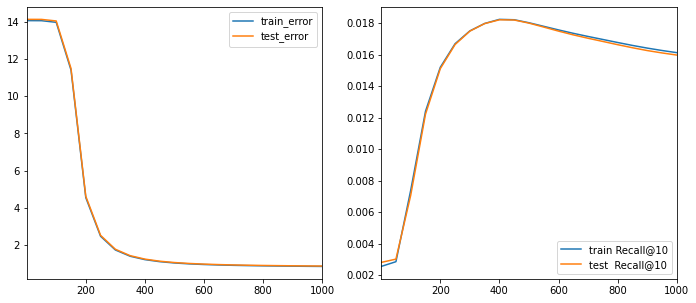

iteration 1000:
train_error 	 = 0.842518
test_error 	 = 0.863818
train Recall@10 	 = 0.016123
test  Recall@10 	 = 0.015970


[{'test_error': 0.8638178, 'train_error': 0.8425179},
 {'test  Recall@10': 0.015969979637609436,
  'train Recall@10': 0.016122944640495875}]

In [ ]:
#@title Solution
model_lowinit = build_model(ratings, embedding_dim=10, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)

In [ ]:
user_recommendations(model_lowinit, measure=DOT, k=20)

dot score  ...                     genres
315       0.947  ...                      Drama
1132      0.920  ...           Animation|Comedy
735       0.917  ...  Animation|Comedy|Thriller
892       0.914  ...           Mystery|Thriller
910       0.913  ...                  Film-Noir
1950      0.912  ...               Action|Drama
1162      0.908  ...                  Drama|War
740       0.905  ...                 Sci-Fi|War
847       0.904  ...         Action|Crime|Drama
1120      0.904  ...                     Comedy
711       0.899  ...                  Animation
1189      0.898  ...                      Drama
1176      0.898  ...                      Drama
2961      0.898  ...       Comedy|Drama|Western
1230      0.898  ...                  Drama|War
2693      0.896  ...                   Thriller
3238      0.895  ...       Comedy|Drama|Romance
941       0.894  ...                      Drama
900       0.894  ...          Drama|Romance|War
3020      0.893  ...                      Drama

[20 rows x 4 columns]

In [ ]:
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...            genres
315       7.639  ...             Drama
523       7.477  ...         Drama|War
1132      7.451  ...  Animation|Comedy
1950      7.448  ...      Action|Drama
2693      7.446  ...          Thriller
1180      7.433  ...  Action|Adventure

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                               genres
584          1.000  ...  Animation|Children's|Comedy|Musical
582          0.997  ...                    Children's|Comedy
3180         0.996  ...                             Thriller
591          0.996  ...         Animation|Children's|Musical
3383         0.996  ...                       Action|Romance
360          0.995  ...         Animation|Children's|Musical

[6 rows x 3 columns]

alt.HConcatChart(...)

## Embedding visualization
Since it is hard to visualize embeddings in a higher-dimensional space (when the embedding dimension $k > 3$), one approach is to project the embeddings to a lower dimensional space. [UMAP](https://github.com/lmcinnes/umap) (Uniform Manifold Approximation and Projection) is an algorithm that projects the embeddings to a lower-dimensional space (a manifold) while attempting to preserve their local distances. It can be useful for visualization, but one should use it with care.

In [ ]:
umap_movie_embeddings(model)

Running UMAP...


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


alt.HConcatChart(...)

You can highlight the embeddings of a given genre by clicking on the genres panel (SHIFT+click to select multiple genres).

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

# V. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by
$$
g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2.
$$

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

### Exercise 6: Build a regularized Matrix Factorization model and train it
Write a function that builds a regularized model. You are given a function `gravity(U, V)` that computes the gravity term given the two embedding matrices $U$ and $V$.


In [ ]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  # ========================= Complete this section ============================
  # error_train =
  # error_test =
  # gravity_loss =
  # regularization_loss =
  # ============================================================================
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error': error_train,
      'test_error': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

In [ ]:
# @title Solution
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  metrics = [
  {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  },
  {
      'train_observed_loss': error_train,
      'train_l2_reg_loss': regularization_loss,
      'train_gravity_loss': gravity_loss,
  },
  {
      'train Recall@10': get_recall(A_train, U, V, k=10),
      'test  Recall@10': get_recall(A_test, U, V, k=10)
  }]
  embeddings = {"user_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, metrics)

It is now time to train the regularized model! You can try different values of the regularization coefficients, and different embedding dimensions.

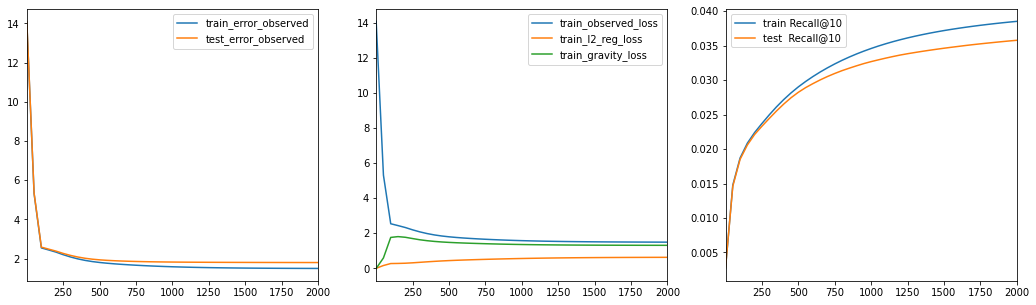

iteration 2000:
train_error_observed 	 = 1.497582
test_error_observed 	 = 1.798634
train_observed_loss 	 = 1.497582
train_l2_reg_loss 	 = 0.633776
train_gravity_loss 	 = 1.317047
train Recall@10 	 = 0.038505
test  Recall@10 	 = 0.035761


[{'test_error_observed': 1.7986343, 'train_error_observed': 1.4975816},
 {'train_gravity_loss': 1.3170475,
  'train_l2_reg_loss': 0.63377565,
  'train_observed_loss': 1.4975816},
 {'test  Recall@10': 0.03576102676974421,
  'train Recall@10': 0.03850494066136983}]

In [ ]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=20,
    init_stddev=0.05)
reg_model.train(num_iterations=2000, learning_rate=40.)

Observe that adding the regularization terms results in a higher MSE, both on the training and test set. However, as we will see, the quality of the recommendations improves. This highlights a tension between fitting the observed data and minimizing the regularization terms. Fitting the observed data often emphasizes learning high similarity (between items with many interactions), but a good embedding representation also requires learning low similarity (between items with few or no interactions).

### Inspect the results
Let's see if the results with regularization look better.

In [ ]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

Hopefully, these recommendations look better. You can change the similarity measure from COSINE to DOT and observe how this affects the recommendations.

Since the model is likely to recommend items that you rated highly, you have the option to exclude the items you rated, using `exclude_rated=True`.

In the following cells, we display the nearest neighbors, the embedding norms, and the t-SNE projection of the movie embeddings.

In [ ]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE, k=20)

Here we compare the embedding norms for `model` and `reg_model`. Selecting a subset of the embeddings will highlight them on both charts simultaneously.

In [ ]:
movie_embedding_norm([model_lowinit, reg_model])

In [ ]:
# Visualize the embeddings
umap_movie_embeddings(reg_model)

We should observe that the embeddings have a lot more structure than the unregularized case. Try selecting different genres and observe how they tend to form clusters (for example Horror, Animation and Children).


## Congratulations!

You have completed this Colab notebook.

If you would like to further explore these models, we encourage you to try different hyperparameters and see how this affects the quality of the model and the structure of the embedding space. Here are some suggestions:
- Change the embedding dimension.
- Using other similarity measures: we used dot product $d(u, V_j) = \langle u, V_j \rangle$ and cosine $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$, and discussed how the norms of the embeddings affect the recommendations. You can also try other variants which apply a transformation to the norm, for example $d(u, V_j) = \frac{\langle u, V_j \rangle}{\|V_j\|^\alpha}$.
- Change your ratings and see how this affects your recommendations.
